# Project - Capstone: US Travel Insights 
### Data Engineering Capstone Project

#### Project Summary
Every year people travel to US cities for various reasons which include business, pleasure and studies. In general there are two categories of travelers 1) domestic and 2) international. In this project, I will be mainly focusing on international travelers and gather data that can facilitate the process of gaining insights on these international travelers. Basically, will try to create a database that can be used to analyze US travel patterns (International travels). 

The goal is for a Data Analyst/Data Scientist to use this database in order to quickly gain further insights on these international travelers. Some analysis that can be performed include 
* Finding insights on age group of the travelers
* Traveler's country of citizenship/residence --> Number of travelers by country
* Duration of stay of these travelers
* Travelers preferrred port of entry
* Months with most number of international travelers visiting US
* Forecast future travel pattern of international travelers
* Analyze the correlate climate/temperature (for a specific month) in the country of origin of these travelers and the month they visit US.

In general, the project follows the following steps:
* Step 1: Scope of the Project and Data Considered
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Project Write Up


In [1]:
# Import libraries
import findspark
findspark.init()
findspark.find()

import pyspark
findspark.find()

import boto3
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import configparser
import country_converter as coco

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, FloatType, ArrayType, Row, DateType, TimestampType

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get AWS Credentials
config = configparser.ConfigParser()
config.read('dl.cfg')

os.environ['AWS_ACCESS_KEY_ID']=config['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['AWS_SECRET_ACCESS_KEY']

In [3]:
# Start Spark Session
def create_spark_session():
    """
    Create SPARK session to process data
    
    Output:
    spark -- SPARK session
    """
    
    spark = SparkSession \
        .builder \
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0") \
        .getOrCreate()
    return spark

spark = create_spark_session()
spark

### Step 1: Scope of the Project and Gather Data

#### Scope 
In this project, I plan to create a database that can be used to analyze US travel patterns, specifically, international travels to US. Using the identified raw data, I will be creating fact and dimensions tables that will facilitate the analysis that can be performed to understand US travel patterns. In general the scope of the project is to create ETL pipeline for processing, cleaning and storing data related US travel patterns. The database will be modeled using Star Schema model as it allows for better query performance.

Expected end solution:
* Expected fact table: US_travel
* Expected dimensions tables: visitor, arrival_calendar, mode_of_entry, visa_category, port_of_entry, country, global_temperature (secondary dimension table)

Tools used:
* SPARK (alternatively could use SPARK instance on AWS EMR)
* PYTHON
* Local storage (alternatively could use S3 storage)


#### Describe and Gather Data 
The datasets used in the project are as follows:

* **I94 Immigration Data**: This data comes from the US National Tourism and Trade Office. (Link: https://www.trade.gov/national-travel-and-tourism-office)
* **World Temperature Data**: This dataset came from Kaggle. (Link: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data)
* **U.S. City Demographic Data**: This data comes from OpenSoft. (Link: https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/)
* **Airport Code Table**: This is a simple table of airport codes and corresponding cities. (Link: https://datahub.io/core/airport-codes#data)
* **i94cnty, i94addr, i94mode, i94prt, i94visa**: These data were extracted from the data dictionary included in the workspace
* **ISO-3166-Countries-with-Regional-Codes**: Data containing ISO country codes with regional codes. (Link: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/tree/master/all) 
* **IP2LOCATION-ISO3166-2**: Data containing IP2Location™ ISO 3166-2 Subdivision Code. (Link: https://www.ip2location.com)


###### Load I94 Immigration Data

In [4]:
# Function to convert sas file to csv file
def convert_sas_to_csv(data_path):
    """
    Convert sas file to csv file
    
    Input arguments:
        data_path -- Source data path
    
    Output:
        convert sas to csv and store in the same directory
    """
    
    files = os.listdir(data_path)
    
    for file_nm in files:
        # Read input sas file
        fname = os.path.join(data_path, file_nm)
        df = pd.read_sas(fname, 'sas7bdat', encoding="ISO-8859-1")
        
        # Store the sas file as csv file
        if not os.path.exists("csv_files"):
            os.makedirs("csv_files")
        
        output_fname = os.path.join("csv_files", file_nm.split('.')[0]+'.csv')
        print(output_fname)
        df.to_csv(output_fname, index=False)
    
    print("Successfully converted all the files to csv")


In [5]:
immigration_data_path = 'immigration_data/18-83510-I94-Data-2016'
convert_sas_to_csv(immigration_data_path)


csv_files\i94_apr16_sub.csv
csv_files\i94_aug16_sub.csv
csv_files\i94_dec16_sub.csv
csv_files\i94_feb16_sub.csv
csv_files\i94_jan16_sub.csv
csv_files\i94_jul16_sub.csv
csv_files\i94_jun16_sub.csv
csv_files\i94_mar16_sub.csv
csv_files\i94_may16_sub.csv
csv_files\i94_nov16_sub.csv
csv_files\i94_oct16_sub.csv
csv_files\i94_sep16_sub.csv
Successfully converted all the files to csv


In [6]:
# Read csv immigration data using spark
file_path = "csv_files" + "/*.csv"
df=spark.read.format("com.databricks.spark.csv").option("header", "true").load(file_path)

print(f"Total number of records in Immigration data: {df.count()}")
print(f"Number of columns/features in Immigration data: {len(df.columns)}")

# View Sample Immigration Data
pd.set_option('display.max_column', 50)
df.limit(5).toPandas()

Total number of records in Immigration data: 40790529
Number of columns/features in Immigration data: 28


,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,None,None,None,37.0,2.0,1.0,None,None,None,T,None,U,None,1979.0,10282016,None,None,None,1897628485.0,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,None,25.0,3.0,1.0,20130811,SEO,None,G,None,Y,None,1991.0,D/S,M,None,None,3736796330.0,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,55.0,2.0,1.0,20160401,None,None,T,O,None,M,1961.0,09302016,M,None,OS,666643185.0,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,28.0,2.0,1.0,20160401,None,None,O,O,None,M,1988.0,09302016,None,None,AA,92468461330.0,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,4.0,2.0,1.0,20160401,None,None,O,O,None,M,2012.0,09302016,None,None,AA,92468463130.0,00199,B2


In [7]:
df.printSchema()

root
 |-- cicid: string (nullable = true)
 |-- i94yr: string (nullable = true)
 |-- i94mon: string (nullable = true)
 |-- i94cit: string (nullable = true)
 |-- i94res: string (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: string (nullable = true)
 |-- i94mode: string (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: string (nullable = true)
 |-- i94bir: string (nullable = true)
 |-- i94visa: string (nullable = true)
 |-- count: string (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: string (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: string (nullable = 

###### Load World Temperature Data

In [8]:
df_temp = spark.read.csv("GlobalLandTemperaturesByCity.csv", inferSchema=True, header=True)

print(f"Total number of records in Immigration data: {df_temp.count()}")
print(f"Number of columns/features in Immigration data: {len(df_temp.columns)}")

# View Sample World Temperature Data
df_temp.limit(5).toPandas()


Total number of records in Immigration data: 8599212
Number of columns/features in Immigration data: 7


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [9]:
df_temp.printSchema()

root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



###### Load U.S. City Demographic Data

In [10]:
df_us_demo = spark.read.csv("us-cities-demographics.csv", inferSchema=True, header=True, sep=";")

print(f"Total number of records in Immigration data: {df_us_demo.count()}")
print(f"Number of columns/features in Immigration data: {len(df_us_demo.columns)}")

# View Sample US Demo Data
df_us_demo.limit(5).toPandas()

Total number of records in Immigration data: 2891
Number of columns/features in Immigration data: 12


,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


In [11]:
df_us_demo.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: integer (nullable = true)
 |-- Female Population: integer (nullable = true)
 |-- Total Population: integer (nullable = true)
 |-- Number of Veterans: integer (nullable = true)
 |-- Foreign-born: integer (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)



###### Load Airport Code Table

In [12]:
df_airport = spark.read.csv("airport-codes_csv.csv", inferSchema=True, header=True)

print(f"Total number of records in Immigration data: {df_airport.count()}")
print(f"Number of columns/features in Immigration data: {len(df_airport.columns)}")

# View Sample Airport Data
df_airport.limit(5).toPandas()

Total number of records in Immigration data: 55075
Number of columns/features in Immigration data: 12


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11,NA,US,US-PA,Bensalem,00A,None,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435,NA,US,US-KS,Leoti,00AA,None,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450,NA,US,US-AK,Anchor Point,00AK,None,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820,NA,US,US-AL,Harvest,00AL,None,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237,NA,US,US-AR,Newport,None,None,None,"-91.254898, 35.6087"


In [13]:
df_airport.printSchema()

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: integer (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)



###### Load Auxiliary Data - i94cnty, i94addr, i94mode, i94prt, i94visa

In [4]:
# Function to clean country names
def standardize_country_name(country_name):
    """
    This function can be used to standardize country names. It basicaly identifies the ISO2 code for a given country
    
    Input arguments:
        country_name: name of the country
    
    Output:
        standardized ISO2
    """
    cc = coco.CountryConverter()
    if ('No Country Code' in country_name):
        return country_name.upper()
    else:
        standard_names = cc.convert(names=country_name, to='ISO2')
        if (type(standard_names)==list):
            standard_names = standard_names[0]
        if standard_names=="not found":
            standard_names = country_name
        return standard_names.upper()


def process_mappings(spark, input_data, column_names, mapping, separator):
    """
    This function can be used to process the mapping files, cleans them 
    and returns a Spark dataframe.
    
    Input arguments:
        spark: SparkSession
        input_data: location for the input data
        output_data: location for the output data
        column_names: name of the columns that will be used for the dataframe schema
        mapping: name of the mapping
        separator: separator to be used when reading the input data
    
    Output:
        spark dataframe
    """
    
    # Read data
    df = pd.read_csv(input_data, sep=separator, header=None, engine='python', names=column_names, skipinitialspace=True)
    
    # remove single quotes from the column at index 1
    df.iloc[:, 1] = df.iloc[:, 1].str.replace("'", "").str.replace("\t", "")
    
    if mapping=="country":
        df["country_ISO2"] = df[column_names[1]].apply(standardize_country_name)
    if mapping=="us_state":
        df.iloc[:, 0] = df.iloc[:, 0].str.replace("'", "").str.replace("\t", "")
    if mapping=="port":
        df.iloc[:, 0] = df.iloc[:, 0].str.replace("'", "").str.replace("\t", "")
        new = df[column_names[1]].str.split(", ", n=1, expand=True) 
        # making separate state column from new data frame 
        df["state"] = new[1].str.strip()
        # replacing the value of city column from new data frame 
        df["city"] = new[0] 
    
    # convert pandas dataframe to spark dataframe
    spark_df = spark.createDataFrame(df)
    
    # Clean string columns
    catCols = [x for (x, dataType) in spark_df.dtypes if dataType=="string"]
    for col in catCols:
        spark_df = spark_df.withColumn(col, F.trim(F.col(col)))
        spark_df = spark_df.withColumn(col, F.when(F.col(col)=='', None).otherwise(F.col(col)))
    
    return spark_df


In [15]:
df_cnty = process_mappings(spark=spark, input_data="i94cnty.txt", column_names=["country_code", "country"], 
                            mapping="country", separator="=")

df_addr = process_mappings(spark=spark, input_data="i94addr.txt", column_names=["state_code", "state"], 
                            mapping="us_state", separator="=")

df_mode = process_mappings(spark=spark, input_data="i94mode.txt", column_names=["mode_code", "mode"], 
                            mapping="mode", separator="=")

df_port = process_mappings(spark=spark, input_data="i94prt.txt", column_names=["port_code", "city_state"], 
                            mapping="port", separator="=")

df_visa = process_mappings(spark=spark, input_data="i94visa.txt", column_names=["visa_code", "visa"], 
                            mapping="visa", separator="=")

More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  

More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  
More then one regular expression match for FAROE ISLANDS (PART OF DENMARK)  

More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More

More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More then one regular expression match for BOUVET ISLAND (ANTARCTICA/NORWAY TERR.)
More

More then one regular expression match for DRONNING MAUD LAND (ANTARCTICA-NORWAY) 
More then one regular expression match for DRONNING MAUD LAND (ANTARCTICA-NORWAY) 
More then one regular expression match for DRONNING MAUD LAND (ANTARCTICA-NORWAY) 
More then one regular expression match for DRONNING MAUD LAND (ANTARCTICA-NORWAY) 
More then one regular expression match for DRONNING MAUD LAND (ANTARCTICA-NORWAY) 
More then one regular expression match for DRONNING MAUD LAND (ANTARCTICA-NORWAY) 
More then one regular expression match for DRONNING MAUD LAND (ANTARCTICA-NORWAY) 
More then one regular expression match for DRONNING MAUD LAND (ANTARCTICA-NORWAY) 
More then one regular expression match for DRONNING MAUD LAND (ANTARCTICA-NORWAY) 
More then one regular expression match for DRONNING MAUD LAND (ANTARCTICA-NORWAY) 
More then one regular expression match for DRONNING MAUD LAND (ANTARCTICA-NORWAY) 
More then one regular expression match for DRONNING MAUD LAND (ANTARCTICA-NORWAY) 
More

###### Load and prepare ISO country and region data

In [16]:
df_iso_country = spark.read.csv(path="ISO-3166-Countries-with-Regional-Codes.csv", inferSchema=True, header=True)
df_iso_subdivision = spark.read.csv(path="IP2LOCATION-ISO3166-2.csv", inferSchema=True, header=True)

df_iso = df_iso_country.join(df_iso_subdivision, df_iso_country["alpha-2"]==df_iso_subdivision["country_code"], how='left')
df_iso = df_iso.withColumnRenamed("name", "country_name")

# Startardize Column Names
df_iso = df_iso.withColumn("country_name", F.upper(F.col("country_name")))
df_iso = df_iso.withColumn("region", F.upper(F.col("region")))
df_iso = df_iso.withColumn("sub-region", F.upper(F.col("sub-region")))
df_iso = df_iso.withColumn("intermediate-region", F.upper(F.col("intermediate-region")))
df_iso = df_iso.withColumn("subdivision_name", F.upper(F.col("subdivision_name")))

print(f"Total number of records in ISO Code data: {df_iso.count()}")
print(f"Number of columns/features in ISO Code data: {len(df_iso.columns)}")

# View ISO Data
df_iso.limit(5).toPandas()

Total number of records in ISO Code data: 3494
Number of columns/features in ISO Code data: 14


,country_name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code,country_code,subdivision_name,code
0,AFGHANISTAN,AF,AFG,4,ISO 3166-2:AF,ASIA,SOUTHERN ASIA,None,142,34,NaN,AF,URUZGAN,AF-URU
1,AFGHANISTAN,AF,AFG,4,ISO 3166-2:AF,ASIA,SOUTHERN ASIA,None,142,34,NaN,AF,TAKHAR,AF-TAK
2,AFGHANISTAN,AF,AFG,4,ISO 3166-2:AF,ASIA,SOUTHERN ASIA,None,142,34,NaN,AF,PARWAN,AF-PAR
3,AFGHANISTAN,AF,AFG,4,ISO 3166-2:AF,ASIA,SOUTHERN ASIA,None,142,34,NaN,AF,PAKTIYA,AF-PIA
4,AFGHANISTAN,AF,AFG,4,ISO 3166-2:AF,ASIA,SOUTHERN ASIA,None,142,34,NaN,AF,PAKTIKA,AF-PKA


### Step 2: Explore and Assess the Data
#### Explore the Data 
All the data was explored and several issues were identified and steps were taken to fix these issues.


#### Cleaning Steps
The following steps were followed in order to clean the data:
* Check for percentage of missing values across all the features in the data --> Filter out features with mostly missing values
* Typecast some features to an appropriate data type
* Check string type features for for trailing spaces. Remove these spaces.
* Check for duplicates and remove the duplicates
* For some features impute missing values
* Standardize some features (e.g. country name)
* Save cleaned data in a directory (staging data)


In [17]:
# Function to find percentage of missing values
def find_missing_values_percentage(spark_df, missing_value_cutoff=60):
    """
    This function can be used to find missing values percentage and filter the features 
    based on percentage of missing values cutoff specified
    
    Input arguments:
        spark_df: spark data frame
        missing_value_cutoff: cutoff for percentage of missing values (Anything above this value will be filtered out)
    
    Output:
        spark_df: filtered spark data frame
        df_missing: information on feature wise percentage of missing values
    """
    
    cols = spark_df.columns
    # Typecast date, timestamp and boolean columns (Also clean and validate string columns)
    for data_type in spark_df.dtypes:
        if data_type[1]=="date" or data_type[1]=="timestamp":
            spark_df = spark_df.withColumn(data_type[0], F.col(data_type[0]).cast(StringType()))
        elif data_type[1]=="boolean":
            spark_df = spark_df.withColumn(data_type[0], F.col(data_type[0]).cast(IntegerType()))
        elif data_type[1]=="string":
            spark_df = spark_df.withColumn(data_type[0], F.trim(F.col(data_type[0])))
            spark_df = spark_df.withColumn(data_type[0], F.when(F.col(data_type[0])=='', None).otherwise(F.col(data_type[0])))
    
    # Find percentage of missing values
    missing_df = spark_df.select([(F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)) / (F.count(F.lit(1))/100)).alias(c) for c in cols])
    
    # Store output as pandas Data Frame
    df_missing = missing_df.toPandas().T
    df_missing.reset_index(inplace=True)
    df_missing.columns = ["features", "percentage_missing_values"]
    
    # Plot Percentage of Missing values vs No of columns
    # Sort results
    df_missing.sort_values("percentage_missing_values", ascending=False, inplace=True)
    df_missing.reset_index(drop=True, inplace=True)
    df_missing.plot(x=None, y="percentage_missing_values", title="Percentage of Missing Values vs No. of Features", figsize=(12, 6), lw=3)
    plt.xlabel("No. of Features")
    plt.ylabel("% Missing")
    plt.grid()
    
    
    # Filter out features with mostly missing values
    features_to_remove = df_missing[df_missing["percentage_missing_values"]>missing_value_cutoff]["features"].tolist()

    print("{} features have greater than {}% missing values".format(len(features_to_remove), missing_value_cutoff))

    # Remove mostly null columns
    spark_df = spark_df.drop(*features_to_remove)
    print(f"Removed features are {features_to_remove}")
    
    # Check the types of columns remaining
    catCols = [x for (x, dataType) in spark_df.dtypes if dataType=="string"]
    numCols = [x for (x, dataType) in spark_df.dtypes if dataType not in ['string', 'timestamp', 'date', 'boolean']]
    dateCols = [x for (x, dataType) in spark_df.dtypes if dataType in ['timestamp', 'date']]
    boolCols = [x for (x, dataType) in spark_df.dtypes if dataType=="boolean"]
    
    # sanity check
    assert len(spark_df.columns)==len(catCols) + len(numCols) + len(dateCols) + len(boolCols)
    print(f"Types of columns: categorical-{len(catCols)}, numerical-{len(numCols)}, date-{len(dateCols)}, boolean-{len(boolCols)}")
    
    return spark_df, df_missing


###### Preprocess and Clean I94 Immigration Data

3 features have greater than 60% missing values
Removed features are ['entdepu', 'occup', 'insnum']
Types of columns: categorical-25, numerical-0, date-0, boolean-0


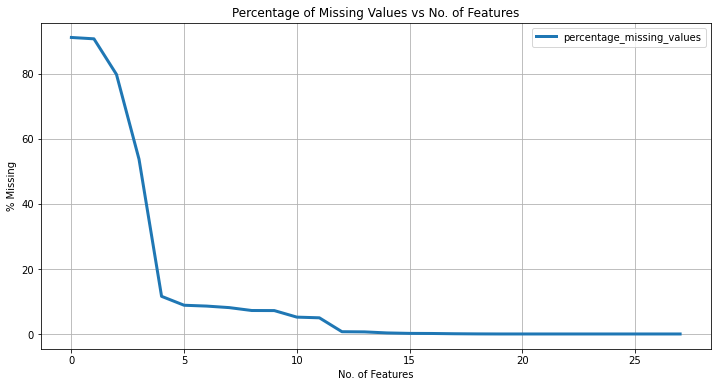

In [18]:
# Filter columns based on percentage of missing values
df, df_immigration_missing = find_missing_values_percentage(df, missing_value_cutoff=60)

# Clean some columns (Typecast to integer)
cast_to_integer = ['i94yr', 'i94mon', 'i94cit', 'i94res', 'arrdate', 'i94mode', 'depdate', 'i94bir', 'i94visa', 'count', 
                   'biryear']
df = df.na.fill({'i94addr': 'Other'})
for col in cast_to_integer:
    df = df.withColumn(col, F.col(col).cast(IntegerType()))

# Convert some columns to proper date
@F.udf(DateType())
def get_timestamp (input_date):
    """
    Convert to date
    
    Input arguments:
        input_date: date to be converted
    
    Output:
        date in proper format
    """
    input_date_int = input_date
    if input_date_int==None:
        return None
    else:
        return (datetime(1960,1,1) + timedelta(days=input_date_int))
df = df.withColumn("arrdate", get_timestamp("arrdate"))
df = df.withColumn("depdate", get_timestamp("depdate"))

# Remove duplicates
df = df.dropDuplicates()

In [19]:
df.printSchema()

root
 |-- cicid: string (nullable = true)
 |-- i94yr: integer (nullable = true)
 |-- i94mon: integer (nullable = true)
 |-- i94cit: integer (nullable = true)
 |-- i94res: integer (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: date (nullable = true)
 |-- i94mode: integer (nullable = true)
 |-- i94addr: string (nullable = false)
 |-- depdate: date (nullable = true)
 |-- i94bir: integer (nullable = true)
 |-- i94visa: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: integer (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: string (nullable = true)
 |-- fltno: string (nullable = true)
 |-- visatype: string (nullable = true)



In [20]:
df.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,entdepa,entdepd,matflag,biryear,dtaddto,gender,airline,admnum,fltno,visatype
0,1000244.0,2016,4,129,129,FTL,2016-04-06,1,Other,2016-06-23,48,2,1,20160406,None,O,I,M,1968,07042016,None,AA,55712675433.0,00095,WT
1,1000715.0,2016,4,130,130,NEW,2016-04-06,1,NY,2016-04-11,40,2,1,20160406,None,G,O,M,1976,07042016,M,SK,55704444733.0,00907,WT
2,1000891.0,2016,4,130,130,HOU,2016-04-06,1,TX,2016-04-17,50,2,1,20160406,None,G,O,M,1966,07042016,F,KL,55705976433.0,00661,WT
3,1000963.0,2016,4,130,130,NYC,2016-04-06,1,NY,2016-04-10,43,2,1,20160406,None,G,O,M,1973,07042016,F,DL,55702858933.0,00049,WT
4,1001080.0,2016,4,130,130,NYC,2016-04-06,1,NY,2016-04-11,49,2,1,20160406,None,G,O,M,1967,07042016,F,AA,55739149733.0,00141,WT


###### Preprocess and Clean World Temperature Data

0 features have greater than 60% missing values
Removed features are []
Types of columns: categorical-5, numerical-2, date-0, boolean-0


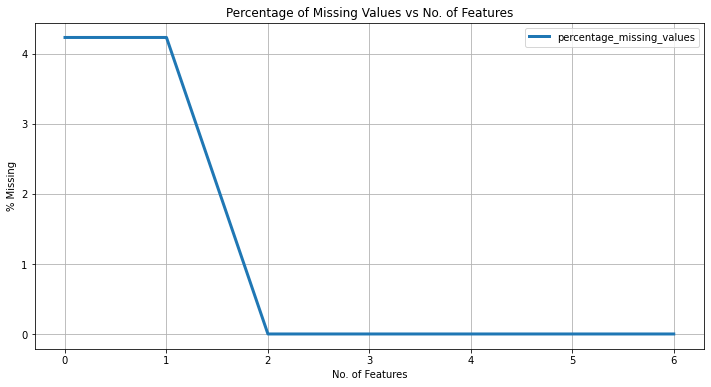

In [21]:
# Filter columns based on percentage of missing values
df_temp, df_temp_missing = find_missing_values_percentage(df_temp, missing_value_cutoff=60)

# Type cast to date column
df_temp = df_temp.withColumn("dt", F.to_date(F.col("dt")))

# Startardize City and Country Columns
df_temp = df_temp.withColumn("Country", F.upper(F.col("Country")))
df_temp = df_temp.withColumn("City", F.upper(F.col("City")))

# Remove missing values
df_temp = df_temp.dropna()

# Remove duplicates
df_temp = df_temp.dropDuplicates()


In [22]:
df_temp.printSchema()

root
 |-- dt: date (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



In [23]:
df_temp.limit(5).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1744-09-01,10.483,2.150,ALMETYEVSK,RUSSIA,55.45N,51.02E
1,1745-01-01,-13.369,2.648,ARKHANGELSK,RUSSIA,65.09N,40.21E
2,1745-02-01,0.439,1.352,AMSTERDAM,NETHERLANDS,52.24N,5.26E
3,1750-01-01,1.313,1.076,AMERSFOORT,NETHERLANDS,52.24N,5.26E
4,1750-01-01,10.119,1.927,ARYANAH,TUNISIA,36.17N,9.94E


###### Preprocess and Clean U.S. City Demographic Data

0 features have greater than 60% missing values
Removed features are []
Types of columns: categorical-4, numerical-8, date-0, boolean-0


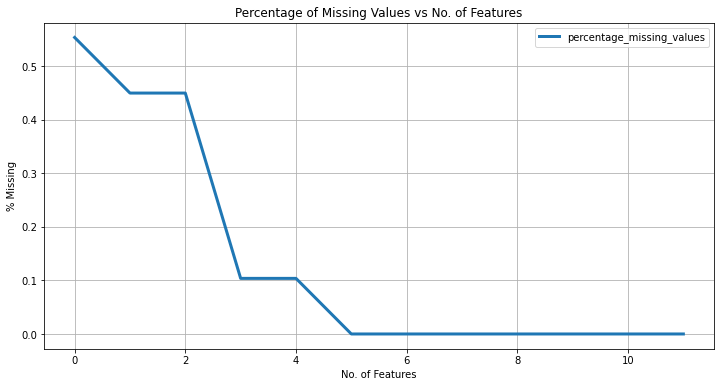

In [24]:
# Filter columns based on percentage of missing values
df_us_demo, df_us_demo_missing = find_missing_values_percentage(df_us_demo, missing_value_cutoff=60)

# Startardize City and State Columns
df_us_demo = df_us_demo.withColumn("State", F.upper(F.col("State")))
df_us_demo = df_us_demo.withColumn("City", F.upper(F.col("City")))

df_us_demo = df_us_demo.withColumnRenamed("Median Age", "median_age")
df_us_demo = df_us_demo.withColumnRenamed("Male Population", "male_population")
df_us_demo = df_us_demo.withColumnRenamed("Female Population", "female_population")
df_us_demo = df_us_demo.withColumnRenamed("Total Population", "total_population")
df_us_demo = df_us_demo.withColumnRenamed("Number of Veterans", "num_veterans")
df_us_demo = df_us_demo.withColumnRenamed("Foreign-born", "foreign_born")
df_us_demo = df_us_demo.withColumnRenamed("Average Household Size", "AverageHouseholdSize")
df_us_demo = df_us_demo.withColumnRenamed("State Code", "StateCode")

# Remove missing values
df_us_demo = df_us_demo.dropna()

# Remove duplicates
df_us_demo = df_us_demo.dropDuplicates()


In [25]:
df_us_demo.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- median_age: double (nullable = true)
 |-- male_population: integer (nullable = true)
 |-- female_population: integer (nullable = true)
 |-- total_population: integer (nullable = true)
 |-- num_veterans: integer (nullable = true)
 |-- foreign_born: integer (nullable = true)
 |-- AverageHouseholdSize: double (nullable = true)
 |-- StateCode: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)



In [26]:
df_us_demo.limit(5).toPandas()

,City,State,median_age,male_population,female_population,total_population,num_veterans,foreign_born,AverageHouseholdSize,StateCode,Race,Count
0,ANAHEIM,CALIFORNIA,33.6,179603,171135,350738,9796,137133,3.45,CA,Hispanic or Latino,201593
1,MIRAMAR,FLORIDA,36.6,66157,70958,137115,3077,57179,3.41,FL,Black or African-American,65840
2,CHARLOTTE,NORTH CAROLINA,34.3,396646,430475,827121,36046,128897,2.52,NC,Hispanic or Latino,113731
3,FORT COLLINS,COLORADO,29.6,80893,80288,161181,8425,9704,2.45,CO,American Indian and Alaska Native,3271
4,MOUNT VERNON,NEW YORK,38.5,31876,36745,68621,2064,23777,2.85,NY,American Indian and Alaska Native,356


###### Preprocess and Clean Airport Code Table

3 features have greater than 20% missing values
Removed features are ['iata_code', 'local_code', 'gps_code']
Types of columns: categorical-8, numerical-1, date-0, boolean-0


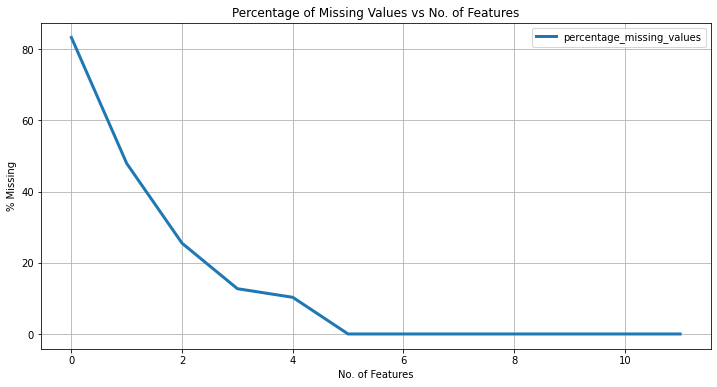

In [27]:
# Filter columns based on percentage of missing values
df_airport = df_airport.withColumnRenamed("name", "airport_name")
df_airport = df_airport.withColumn("municipality", F.upper(F.col("municipality")))
df_airport = df_airport.withColumn("type", F.upper(F.col("type")))
df_airport = df_airport.withColumn("airport_name", F.upper(F.col("airport_name")))

df_airport, df_airport_missing = find_missing_values_percentage(df_airport, missing_value_cutoff=20)

# Join with ISO table
df_airport = df_airport.join(df_iso, 
                             (df_iso["country_code"]==df_airport["iso_country"])&
                             (df_iso["code"]==df_airport["iso_region"]), 
                             how='left')

# Remove duplicates
df_airport = df_airport.dropDuplicates()

In [28]:
df_airport.printSchema()

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- airport_name: string (nullable = true)
 |-- elevation_ft: integer (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- alpha-2: string (nullable = true)
 |-- alpha-3: string (nullable = true)
 |-- country-code: integer (nullable = true)
 |-- iso_3166-2: string (nullable = true)
 |-- region: string (nullable = true)
 |-- sub-region: string (nullable = true)
 |-- intermediate-region: string (nullable = true)
 |-- region-code: integer (nullable = true)
 |-- sub-region-code: integer (nullable = true)
 |-- intermediate-region-code: integer (nullable = true)
 |-- country_code: string (nullable = true)
 |-- subdivision_name: string (nullable = true)
 |-- code: string (nullable = true)



In [29]:
pd.set_option('display.max_column', 50)
df_airport.limit(5).toPandas()

,ident,type,airport_name,elevation_ft,continent,iso_country,iso_region,municipality,coordinates,country_name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code,country_code,subdivision_name,code
0,SCAD,SMALL_AIRPORT,SANTA ADRIANA AIRPORT,558,SA,CL,CL-CO,OVALLE,"-71.27305603027344, -30.628610610961914",CHILE,CL,CHL,152,ISO 3166-2:CL,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,SOUTH AMERICA,19,419,5,CL,COQUIMBO,CL-CO
1,SCCB,SMALL_AIRPORT,PEDRO VILLARROEL C. AIRPORT,3002,SA,CL,CL-CO,COMBARBALA,"-71.07027435302734, -31.22194480895996",CHILE,CL,CHL,152,ISO 3166-2:CL,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,SOUTH AMERICA,19,419,5,CL,COQUIMBO,CL-CO
2,SCCG,SMALL_AIRPORT,LA PELÃ­CANA AIRPORT,2790,SA,CL,CL-CO,COMBARBALA,"-70.9544448852539, -31.063888549804688",CHILE,CL,CHL,152,ISO 3166-2:CL,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,SOUTH AMERICA,19,419,5,CL,COQUIMBO,CL-CO
3,SCCQ,SMALL_AIRPORT,TAMBILLOS AIRPORT,656,SA,CL,CL-CO,COQUIMBO,"-71.246944, -30.198889",CHILE,CL,CHL,152,ISO 3166-2:CL,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,SOUTH AMERICA,19,419,5,CL,COQUIMBO,CL-CO
4,SCDI,SMALL_AIRPORT,PICHIDANGUI AIRPORT,98,SA,CL,CL-CO,PICHIDANGUI,"-71.50527954101562, -32.1430549621582",CHILE,CL,CHL,152,ISO 3166-2:CL,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,SOUTH AMERICA,19,419,5,CL,COQUIMBO,CL-CO


##### Save Staging Data

In [30]:
staging_data_path = "staging_data"
if not os.path.exists(staging_data_path):
    os.makedirs(staging_data_path)


df.write.mode("overwrite").csv(staging_data_path+"/i94_immigration_data.csv", header=True)
df_temp.write.mode("overwrite").csv(staging_data_path+"/temp_data.csv", header=True)
df_us_demo.write.mode("overwrite").csv(staging_data_path+"/demo_data.csv", header=True)
df_airport.write.mode("overwrite").csv(staging_data_path+"/airport_data.csv", header=True)

df_cnty.write.mode("overwrite").csv(staging_data_path+"/country_code.csv", header=True)
df_addr.write.mode("overwrite").csv(staging_data_path+"/addr_code.csv", header=True)
df_mode.write.mode("overwrite").csv(staging_data_path+"/mode_code.csv", header=True)
df_port.write.mode("overwrite").csv(staging_data_path+"/port_code.csv", header=True)
df_visa.write.mode("overwrite").csv(staging_data_path+"/visa_code.csv", header=True)


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model
The database was modeled using Star Schema model which consists of 1 Fact table, 6 Dimension tables and 1 Secondary Dimension table. Star schema was selected for following reasons:
* Improved query performance
* Faster load performance
* Can be easily understood by data analyst

Proposed Data Model:
![star_schema](star_schema_cap_high.png)


#### 3.2 Mapping Out Data Pipelines
Steps necessary to pipeline the data into the chosen data model:
* Load data (e.g. from local or Amazon S3)
* Clean the data (handle missing values, data type, standardize features)
* Save preprocessed and cleaned table as staging table
* Load data from staging table
* Extract relevant features to create dimension tables and fact table
* Perform quality checks on the dimensions and fact tables
* If it passed quality checks, store the tables (e.g. as parquet, csv, etc. on Amazon S3 or local)


### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Running the following cell will create the database with the expected data model

#### 4.2 Data Quality Checks
Data quality checks that will be performed include:
* Checking whether records are being inserted in the dimension and fact tables
* Validate whether the primary key is unique for the tables
* While exteacting features, extra care will be taken to remove duplicate records


###### Load Staging Data

In [5]:
staging_data_path = "staging_data"

df = spark.read.csv(staging_data_path+"/i94_immigration_data.csv", inferSchema=True, header=True)
df_temp = spark.read.csv(staging_data_path+"/temp_data.csv", inferSchema=True, header=True)
df_us_demo = spark.read.csv(staging_data_path+"/demo_data.csv", inferSchema=True, header=True)
df_airport = spark.read.csv(staging_data_path+"/airport_data.csv", inferSchema=True, header=True)

df_cnty = spark.read.csv(staging_data_path+"/country_code.csv", inferSchema=True, header=True)
df_addr = spark.read.csv(staging_data_path+"/addr_code.csv", inferSchema=True, header=True)
df_mode = spark.read.csv(staging_data_path+"/mode_code.csv", inferSchema=True, header=True)
df_port = spark.read.csv(staging_data_path+"/port_code.csv", inferSchema=True, header=True)
df_visa = spark.read.csv(staging_data_path+"/visa_code.csv", inferSchema=True, header=True)


In [6]:
# Function to check data quality
def check_data_quality(spark_df, table_name, primary_key):
    """
    This function can be used to perform data quality checks
    
    Input arguments
        spark_df: Spark Dataframe
        table_name: Name of the table
        primary_key: Name of the primary key
    
    Output:
        Whether the tables has PASSED or FAILED the quality checks
    """
    result = spark_df.count()
    pk_count = spark_df.select(primary_key).dropna().count()
    
    # Check whether records are inserted into the table
    if result==0:
        print(f"No record was inserted into {table_name}")
        success=0
    else:
        print(f"{result} records was inserted into {table_name}")
        success=1
    
    # Check whether primary key contains null values
    if pk_count!=result:
        print(f"Primary key for {table_name} contains null values")
        success2=0
    else:
        print(f"No null values in primary key for {table_name}")
        success2=1
    
    # Determine whether the table has passed all the tests
    if (success and success2):
        print(f"Table {table_name} has PASSED quality checks")
    else:
        print(f"Table {table_name} has FAILED quality checks")

In [7]:
# Path to store Fact and Dimension Tables
dim_table_path = "dim_data"
fact_table_path = "fact_data"


if not os.path.exists(dim_table_path):
    os.makedirs(dim_table_path)

if not os.path.exists(fact_table_path):
    os.makedirs(fact_table_path)

###### Create Global Temperature secondary dimension table

In [13]:
# Get Country code from i94cnty
df_temp_fil = df_temp.withColumn("month", F.month(F.col("dt"))) \
                    .select("Country", "AverageTemperature", "AverageTemperatureUncertainty", "month") \
                    .groupBy("Country", "month") \
                    .agg(F.avg("AverageTemperature").alias("average_temperature"), 
                         F.avg("AverageTemperatureUncertainty").alias("average_temperature_uncertainty")) \
                    .withColumnRenamed("Country", "country")

temp_pd = df_temp_fil.toPandas()
temp_pd["country_ISO2"] = temp_pd["country"].apply(standardize_country_name)
df_temp_fil = spark.createDataFrame(temp_pd)

df_cnty_fil = df_cnty.withColumnRenamed("country", "i94_country") \
                    .withColumnRenamed("country_ISO2", "i94_country_ISO2")

df_temp_sec_dim = df_temp_fil.join(df_cnty_fil, 
                                   df_temp_fil["country_ISO2"]==df_cnty_fil["i94_country_ISO2"], 
                                   how="left").drop(*["i94_country", "i94_country_ISO2"]) \
                            .withColumnRenamed("country_ISO2", "country_alpha_2_code") \
                            .dropDuplicates(["country_alpha_2_code", "month"]) \
                            .withColumn("global_temp_id", F.monotonically_increasing_id()) \
                            .select("global_temp_id", "country_alpha_2_code", "country", "month", 
                                    "average_temperature", "average_temperature_uncertainty") \
                            .orderBy("country_alpha_2_code", "month")

# Check data quality
check_data_quality(spark_df=df_temp_sec_dim, table_name="global_temperature", primary_key="global_temp_id")

df_temp_sec_dim.write.mode("overwrite").csv(dim_table_path+"/global_temperature", header=True)
print("global temperature secondary dimension table saved")

1908 records was inserted into global_temperature
No null values in primary key for global_temperature
Table global_temperature has PASSED quality checks
global temperature secondary dimension table saved


In [14]:
df_temp_sec_dim.printSchema()

root
 |-- global_temp_id: long (nullable = false)
 |-- country_alpha_2_code: string (nullable = true)
 |-- country: string (nullable = true)
 |-- month: long (nullable = true)
 |-- average_temperature: double (nullable = true)
 |-- average_temperature_uncertainty: double (nullable = true)



###### Create Country dimension table

In [15]:
df_airport_fil = df_airport.select(*["continent", "country_name", "alpha-2", "alpha-3", "iso_3166-2", 
                                     "region", "sub-region", "intermediate-region", "region-code", 
                                     "sub-region-code", "intermediate-region-code"]) \
                        .dropna(subset=("country_name")).dropDuplicates(["country_name"])

df_cnty_fil = df_cnty.withColumnRenamed("country", "i94_country") \
                    .withColumnRenamed("country_ISO2", "i94_country_ISO2")

df_country_dim = df_cnty_fil.join(df_airport_fil, 
                                  df_airport_fil["alpha-2"]==df_cnty_fil["i94_country_ISO2"], 
                                  how="left") \
                        .drop(*["alpha-2", "country_name"]) \
                        .withColumnRenamed("i94_country", "country_name") \
                        .withColumnRenamed("i94_country_ISO2", "country_alpha_2_code") \
                        .withColumnRenamed("alpha-3", "country_alpha_3_code") \
                        .dropna(subset=("country_alpha_2_code")) \
                        .select("country_alpha_2_code", "country_alpha_3_code", "country_name", 
                                "continent", "iso_3166-2", "region", "sub-region", "intermediate-region") \
                        .dropDuplicates(["country_alpha_2_code"]) \
                        .orderBy("country_alpha_2_code", "country_name")

# Check data quality
check_data_quality(spark_df=df_country_dim, table_name="country", primary_key="country_alpha_2_code")

df_country_dim.write.mode("overwrite").csv(dim_table_path+"/country", header=True)
print("country dimension table saved")

279 records was inserted into country
No null values in primary key for country
Table country has PASSED quality checks
country dimension table saved


In [16]:
df_country_dim.printSchema()

root
 |-- country_alpha_2_code: string (nullable = true)
 |-- country_alpha_3_code: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_3166-2: string (nullable = true)
 |-- region: string (nullable = true)
 |-- sub-region: string (nullable = true)
 |-- intermediate-region: string (nullable = true)



###### Create visitor dimension table

In [8]:
df_visitor_dim = df.select("admnum", "i94bir", "gender", "biryear", "i94addr", 
                           "visapost", "entdepa", "entdepd", "matflag") \
                    .withColumn("i94addr", F.upper(F.col("i94addr"))) \
                    .withColumnRenamed("admnum", "admission_number") \
                    .withColumnRenamed("i94bir", "age") \
                    .withColumnRenamed("biryear", "birth_year") \
                    .withColumnRenamed("i94addr", "destination_us_state") \
                    .dropna(subset=("admission_number")) \
                    .dropDuplicates(["admission_number"])

In [11]:
# Check data quality
check_data_quality(spark_df=df_visitor_dim, table_name="visitor", primary_key="admission_number")

36774585 records was inserted into visitor
No null values in primary key for visitor
Table visitor has PASSED quality checks


In [9]:
df_visitor_dim.repartition(300).write.mode("overwrite").csv(dim_table_path +"/visitor", header=True)
print("visitor dimension table saved")

visitor dimension table saved


In [10]:
df_visitor_dim.printSchema()

root
 |-- admission_number: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- birth_year: integer (nullable = true)
 |-- destination_us_state: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- matflag: string (nullable = true)



###### Create arrival_calendar dimension table

In [12]:
df_arrival_calendar_dim = df.select("arrdate").dropna().distinct() \
                            .withColumnRenamed("arrdate", "arrival_date") \
                            .withColumn("year", F.year("arrival_date")) \
                            .withColumn("month", F.month("arrival_date")) \
                            .withColumn("day_of_week", F.dayofweek("arrival_date")) \
                            .withColumn("day_of_month", F.dayofmonth("arrival_date")) \
                            .withColumn("day_of_year", F.dayofyear("arrival_date")) \

# Check data quality
check_data_quality(spark_df=df_arrival_calendar_dim, table_name="arrival_calendar", primary_key="arrival_date")

df_arrival_calendar_dim.write.mode("overwrite").csv(dim_table_path +"/arrival_calendar", header=True)
print("arrival calendar dimension table saved")

366 records was inserted into arrival_calendar
No null values in primary key for arrival_calendar
Table arrival_calendar has PASSED quality checks
arrival calendar dimension table saved


In [13]:
df_arrival_calendar_dim.printSchema()

root
 |-- arrival_date: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_year: integer (nullable = true)



###### Create port of entry dimension table

In [14]:
df_port_fil = df_port.select("port_code", "city", "state") \
                    .dropna(subset=("port_code")) \
                    .dropDuplicates(["port_code"]) \
                    .withColumnRenamed("state", "port_state_code") \
                    .withColumnRenamed("city", "port_city")                    


df_us_demo_fil = df_us_demo.select("City", "State", "median_age", "male_population", 
                                   "female_population", "total_population", "num_veterans", 
                                   "foreign_born", "AverageHouseholdSize", "StateCode") \
                        .dropna(subset=("City", "StateCode")) \
                        .dropDuplicates(["City", "StateCode"])

df_port_dim = df_port_fil.join(df_us_demo_fil, 
                               (df_port_fil['port_city']==df_us_demo_fil["City"]) & 
                               (df_port_fil['port_state_code']==df_us_demo_fil["StateCode"]), 
                               how='left') \
                        .select("port_code", "port_city", "port_state_code", "median_age", 
                                "male_population", "female_population", "total_population", 
                                "num_veterans", "foreign_born", "AverageHouseholdSize") \
                        .dropDuplicates()

# Check data quality
check_data_quality(spark_df=df_port_dim, table_name="port_of_entry", primary_key="port_code")

df_port_dim.write.mode("overwrite").csv(dim_table_path +"/port_of_entry", header=True)
print("port of entry dimension table saved")


660 records was inserted into port_of_entry
No null values in primary key for port_of_entry
Table port_of_entry has PASSED quality checks
port of entry dimension table saved


In [15]:
df_port_dim.printSchema()

root
 |-- port_code: string (nullable = true)
 |-- port_city: string (nullable = true)
 |-- port_state_code: string (nullable = true)
 |-- median_age: double (nullable = true)
 |-- male_population: integer (nullable = true)
 |-- female_population: integer (nullable = true)
 |-- total_population: integer (nullable = true)
 |-- num_veterans: integer (nullable = true)
 |-- foreign_born: integer (nullable = true)
 |-- AverageHouseholdSize: double (nullable = true)



###### Create mode of entry dimension table

In [16]:
# Check data quality
check_data_quality(spark_df=df_mode, table_name="mode_of_entry", primary_key="mode_code")

df_mode.write.mode("overwrite").csv(dim_table_path +"/mode_of_entry", header=True)
print("mode of entry dimension table saved")

4 records was inserted into mode_of_entry
No null values in primary key for mode_of_entry
Table mode_of_entry has PASSED quality checks
mode of entry dimension table saved


In [17]:
df_mode.printSchema()

root
 |-- mode_code: integer (nullable = true)
 |-- mode: string (nullable = true)



###### Create visa category dimension table

In [18]:
df_visa = df_visa.withColumnRenamed("visa", "visa_category")

# Check data quality
check_data_quality(spark_df=df_visa, table_name="visa_category", primary_key="visa_code")

df_visa.write.mode("overwrite").csv(dim_table_path +"/visa_category", header=True)
print("visa category dimension table saved")

3 records was inserted into visa_category
No null values in primary key for visa_category
Table visa_category has PASSED quality checks
visa category dimension table saved


In [19]:
df_visa.printSchema()

root
 |-- visa_code: integer (nullable = true)
 |-- visa_category: string (nullable = true)



###### Create us travel fact table

In [20]:
df = df.select("i94res", "admnum", "arrdate", "i94port", "i94mode", 
               "depdate", "i94visa", "dtaddto", "visatype").dropDuplicates()


In [21]:
df = df.join(df_cnty, (df['i94res']==df_cnty["country_code"]), how='left') \
        .drop(*["i94res", "country_code"]) \
        .withColumnRenamed("country", "country_of_residence") \
        .withColumnRenamed("country_ISO2", "country_alpha_2_code") \
        .withColumnRenamed("admnum", "admission_number") \
        .withColumnRenamed("arrdate", "arrival_date") \
        .withColumnRenamed("i94port", "port_code") \
        .withColumnRenamed("i94mode", "mode_code") \
        .withColumnRenamed("i94visa", "visa_code") \
        .withColumnRenamed("dtaddto", "admit_until") \
        .withColumnRenamed("depdate", "departure_date") \
        .withColumn("duration_of_stay", F.datediff(F.col("departure_date"), F.col("arrival_date"))) \
        .dropna(subset=("admission_number", "country_alpha_2_code", "arrival_date", "port_code", "mode_code", "visa_code")) \
        .dropDuplicates(["admission_number", "country_alpha_2_code", "arrival_date", "port_code", "mode_code", "visa_code"]) \
        .withColumn("travel_id", F.monotonically_increasing_id()) \
        .select("travel_id", "admission_number", "country_alpha_2_code", "arrival_date", 
                "port_code", "mode_code", "visa_code", "visatype", "admit_until", "duration_of_stay")

# Check data quality
check_data_quality(spark_df=df, table_name="US_travel", primary_key="travel_id")

df.repartition(1000).write.mode("overwrite").csv(fact_table_path +"/US_travel", header=True)
print("US_travel fact table saved")

37333550 records was inserted into US_travel
No null values in primary key for US_travel
Table US_travel has PASSED quality checks
US_travel fact table saved


In [22]:
df.printSchema()

root
 |-- travel_id: long (nullable = false)
 |-- admission_number: string (nullable = true)
 |-- country_alpha_2_code: string (nullable = true)
 |-- arrival_date: string (nullable = true)
 |-- port_code: string (nullable = true)
 |-- mode_code: integer (nullable = true)
 |-- visa_code: integer (nullable = true)
 |-- visatype: string (nullable = true)
 |-- admit_until: string (nullable = true)
 |-- duration_of_stay: integer (nullable = true)



#### 4.3 Data dictionary 

###### US_travel (fact table)
This table contains data about people traveling to US. Data in this table can be used to understand the travel pattern to US.

In [23]:
pd.read_excel("data_dictionary.xlsx", sheet_name="US_travel")

,Feature,Description
0,travel_id,traveler id
1,country_alpha_2_code,two letter country code
2,admission_number,admission record number
3,arrival_date,Arrival Date in the USA
4,port_code,port of entry code
5,mode_code,mode of entry code
6,visa_code,visa code
7,visatype,type of visa issued
8,admit_until,period allowed to stay until in U.S.
9,duration_of_stay,duration of stay


###### visitor (dimension table)
This table contains general information about the visitor who visits US.

In [24]:
pd.read_excel("data_dictionary.xlsx", sheet_name="visitor")

,Feature,Description
0,admission_number,admission record number
1,age,age of the visitor
2,gender,gender of the visitor
3,birth_year,birth year of the visitor
4,destination_us_state,state code of destination state
5,visapost,Department of State where where Visa was issued
6,entdepa,Arrival Flag - admitted or paroled into the U.S.
7,entdepd,"Departure Flag - Departed, lost I-94 or is dec..."
8,matflag,Match flag - Match of arrival and departure re...


###### arrival_calendar (dimension table)
This table contains data related to arrival date. Supporting table for performing date based analysis.

In [25]:
pd.read_excel("data_dictionary.xlsx", sheet_name="arrival_calendar")

,Feature,Description
0,arrival_date,Arrival Date in the USA
1,year,year
2,month,month of the year
3,day_of_week,day of week
4,day_of_month,day of month
5,day_of_year,day of year


###### mode_of_entry (dimension table)
This table contains description of mode of entry.

In [26]:
pd.read_excel("data_dictionary.xlsx", sheet_name="mode_of_entry")

,Feature,Description
0,mode_code,mode of entry code
1,mode,mode of entry


###### port_of_entry (dimension table)
This table contains description of port of entry along with the demographics of the port of entry city.

In [27]:
pd.read_excel("data_dictionary.xlsx", sheet_name="port_of_entry")

,Feature,Description
0,port_code,port of entry code
1,port_city,port of entry city
2,port_state_code,port of entry state code
3,median_age,median age of the city
4,male_population,male population in the city
5,female_population,female population in the city
6,total_population,total population in the city
7,num_veterans,num veterans in the city
8,foreign_born,foreign born in the city
9,AverageHouseholdSize,average household size


###### visa_category (dimension table)
This table contains description of high level visa category.

In [28]:
pd.read_excel("data_dictionary.xlsx", sheet_name="visa_category")

,Feature,Description
0,visa_code,visa code
1,visa_category,general category of visa


###### country (dimension table)
This table contains information about the countries of travelers.

In [29]:
pd.read_excel("data_dictionary.xlsx", sheet_name="country")

,Feature,Description
0,country_alpha_2_code,two letter country code
1,country_alpha_3_code,three letter country code
2,country_name,country name
3,continent,continent where the country is located
4,iso_3166-2,code for identfying principal subdivisions
5,region,region the country is located
6,sub-region,sub-region the country is located
7,intermediate-region,intermediate-region the country is located


###### global_temperature (secondary dimension table)
This table contains information about average climate in a specific country by month.

In [30]:
pd.read_excel("data_dictionary.xlsx", sheet_name="global_temperature")

,Feature,Description
0,global_temp_id,global temperature id
1,country_alpha_2_code,two letter country code
2,country,country name
3,month,month of the year
4,average_temperature,average temperature
5,average_temperature_uncertainty,standard deviation of the average temperature


#### Step 5: Project Write Up
* Rationale for the choice of tools and technologies for the project:
    * Apache SPARK was used because of its ability to handle Big Data, multiple file formats, offers a lightning-fast unified analytics engine for big data, easy-to-use APIs
    * PYTHON was used because it has some easy to use libraries and function for processing data
* How often the data should be updated?
    * Assuming new travel records will be available monthly, the data can be updated monthly
* Description on handling different scenarios:
    * The data was increased by 100x
        * Utilize clustered SPARK to enable parallel processing of the data
        * Store the data in a distributed platform like Hadoop or Amazon S3
        * Utilize Amazon EMR
    * The data populates a dashboard that must be updated on a daily basis by 7am every day
        * Utilize Apache Airflow. Schedule the script to run daily and complete by 7am every day
    * The database needed to be accessed by 100+ people
        * Migrate the database to Amazon Redshift. This will ensure that the database to be accessed by many people.
        * Ensure that the tables are created in such a way that it can perform queries by various people faster and efficiently
